# SoftRas

## Setup Environment

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
!wget https://raw.githubusercontent.com/Korusuke/DLProject/main/softras.yml

--2022-12-21 03:16:46--  https://raw.githubusercontent.com/Korusuke/DLProject/main/softras.yml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6208 (6.1K) [text/plain]
Saving to: ‘softras.yml’

softras.yml         100%[===================>]   6.06K  --.-KB/s    in 0s      

2022-12-21 03:16:46 (72.9 MB/s) - ‘softras.yml’ saved [6208/6208]



In [ ]:
!conda env update -n base -f softras.yml

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | 

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


## Get Code and Model checkpoint

In [ ]:
!git clone https://github.com/ShichenLiu/SoftRas.git
!cd SoftRas && /usr/local/bin/python -m pip install .

Cloning into 'SoftRas'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 286 (delta 141), reused 233 (delta 139), pack-reused 36
Receiving objects: 100% (286/286), 10.73 MiB | 14.57 MiB/s, done.
Resolving deltas: 100% (141/141), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/SoftRas
  Preparing metadata (setup.py) ... done
  Created wheel for soft-renderer: filename=soft_renderer-1.0.0-cp38-cp38-linux_x86_64.whl size=553737 sha256=967052a9f8b688731b664e0ab23ea238b26043e28c1a5c6fd98eba9de55846a9
  Stored in directory: /tmp/pip-ephem-wheel-cache-rzmkff8a/wheels/ac/46/ee/fcbf77e759bea54b02554a5f3a862d514a4974d1038e94c232
Successfully built soft-renderer


In [ ]:
!gdown 1r63AKNn3ecMho6RFE7gFefRv78Pmbe5h

Downloading...
From: https://drive.google.com/uc?id=1r63AKNn3ecMho6RFE7gFefRv78Pmbe5h
To: /content/softras_shading_checkpoint.pth.tar
100% 108M/108M [00:03<00:00, 34.7MB/s] 


## Demo

### Import Everything

In [ ]:
import torch
import torch.nn.parallel
import soft_renderer as sr
import soft_renderer.functional as srf
import matplotlib.image as mpimg
from SoftRas.examples.recon import models
from SoftRas.examples.recon import models_large
import os
import imageio
import numpy as np

/usr/local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


### Helper Functions

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def img_cvt(images):
    return (255. * images).detach().cpu().numpy().clip(0, 255).astype('uint8').transpose(1, 2, 0)

def rev_img(image):
    return torch.from_numpy(image.transpose(2,0,1).astype('float32'))     

In [ ]:
IMAGE_SIZE = 64
CLASS_IDS_ALL = (
    '02691156,02828884,02933112,02958343,03001627,03211117,03636649,' +
    '03691459,04090263,04256520,04379243,04401088,04530566')

MODEL_DIRECTORY = '/content/softras_shading_checkpoint.pth.tar'

SHADING = True
SIGMA_VAL = 0.01
IMAGE_PATH = '/content/test.png'
OBJ_PATH = '/content/test.obj'

In [ ]:
class Args:
    image_size = IMAGE_SIZE
    sigma_val = SIGMA_VAL

args=Args()

### Visualize input image

In [ ]:
from PIL import Image
im = Image.open(IMAGE_PATH)
im = im.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
im.save(IMAGE_PATH)

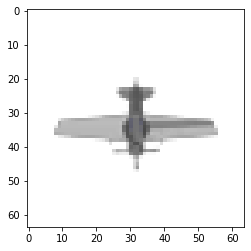

In [ ]:
import matplotlib.pyplot as plt

im = mpimg.imread(IMAGE_PATH)
plt.imshow(im)

### Import pretrained Model and Generate obj

In [ ]:
if SHADING:
    model = models_large.Model('SoftRas/data/obj/sphere/sphere_642.obj', args=args)
else:
    model = models.Model('SoftRas/data/obj/sphere/sphere_642.obj', args=args)

model = model.cuda()
state_dicts = torch.load(MODEL_DIRECTORY)

model.load_state_dict(state_dicts['model'], strict=True)
model.eval()

Model(
  (encoder): Encoder(
    (conv1): Conv2d(4, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv5): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=16384, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_feature

In [ ]:
image = rev_img(im).reshape(-1,4,64,64)
image = torch.autograd.Variable(image).cuda()
print(image.shape)

torch.Size([1, 4, 64, 64])


In [ ]:
vertices, faces = model.reconstruct(image)
srf.save_obj(OBJ_PATH, vertices[0], faces[0])



### Visualize OBJ


In [ ]:
from obj2html import obj2html
from IPython.display import display, HTML

obj2html(OBJ_PATH, 'index.html')

display(HTML('index.html'))